In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
data_dir = './data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [3]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [6]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [7]:
traininglosses = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            traininglosses.append(running_loss/print_every)
            testinglosses.append(test_loss/len(testloader))
            testaccuracy.append(accuracy/len(testloader))
            totalsteps.append(steps)
            print(f"Device {device}.."
                  f"Epoch {epoch+1}/{epochs}.. "
                  f"Step {steps}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Device cuda..Epoch 1/1.. Step 5.. Train loss: 1.032.. Test loss: 0.630.. Test accuracy: 0.495
Device cuda..Epoch 1/1.. Step 10.. Train loss: 0.568.. Test loss: 0.382.. Test accuracy: 0.903
Device cuda..Epoch 1/1.. Step 15.. Train loss: 0.309.. Test loss: 0.095.. Test accuracy: 0.967
Device cuda..Epoch 1/1.. Step 20.. Train loss: 0.221.. Test loss: 0.071.. Test accuracy: 0.973
Device cuda..Epoch 1/1.. Step 25.. Train loss: 0.225.. Test loss: 0.059.. Test accuracy: 0.977
Device cuda..Epoch 1/1.. Step 30.. Train loss: 0.230.. Test loss: 0.084.. Test accuracy: 0.967
Device cuda..Epoch 1/1.. Step 35.. Train loss: 0.256.. Test loss: 0.106.. Test accuracy: 0.961
Device cuda..Epoch 1/1.. Step 40.. Train loss: 0.250.. Test loss: 0.067.. Test accuracy: 0.981
Device cuda..Epoch 1/1.. Step 45.. Train loss: 0.164.. Test loss: 0.059.. Test accuracy: 0.983
Device cuda..Epoch 1/1.. Step 50.. Train loss: 0.131.. Test loss: 0.051.. Test accuracy: 0.983
Device cuda..Epoch 1/1.. Step 55.. Train loss: 0.14

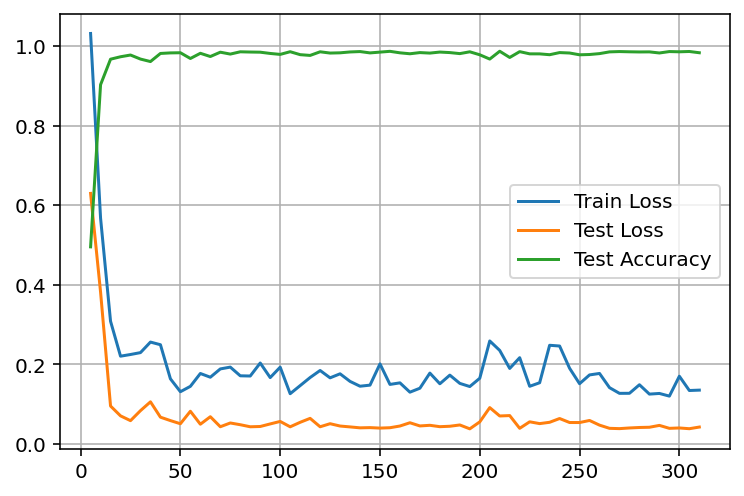

In [8]:
from matplotlib import pyplot as plt
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')
plt.plot(totalsteps, testaccuracy, label='Test Accuracy')
plt.legend()
plt.grid()
plt.show()

In [9]:
checkpoint = {
    'parameters' : model.parameters,
    'state_dict' : model.state_dict()
}

In [10]:
torch.save(checkpoint, './catvdog.pth')